In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit
from datetime import datetime
import matplotlib.image as mpimg

In [2]:
## Define Functions

## ECEF to Geodedic LLH
def ecef2llh_geodedic(ECEF):
    accuracy = 0.000001
    EarthR = 6378137
    e = 0.081812

    x,y,z = ECEF

    # Initial Values
    height = 0
    R = np.sqrt(x**2 + y**2)
    n = EarthR
    phi = 100
    phi0 = 0

    while abs(phi-phi0) > accuracy:
        sinphi = z/(height+(n*(1 - e**2)))
        phi = np.arctan((z + (e**2)*n*sinphi)/R)
        n = EarthR/np.sqrt(1 - (e**2)*(np.sin(phi)**2))

        height = R/np.cos(phi) - n

        phi0 = phi
    
    return np.array([np.degrees(phi),np.degrees(np.arctan2(y,x)),height])

## ECI to ECEF
def eci2ecef(ECI, time):
    w = 7.292115*10**(-5)

    ECEF = np.zeros_like(ECI)

    theta = w * time

    C = np.array([[np.cos(theta), np.sin(theta), 0], 
                    [-np.sin(theta), np.cos(theta), 0], 
                    [0, 0, 1]])
        
    ECEF = np.dot(C, ECI)
    return ECEF

def ecef2eci(ECEF, time):
    w = 7.292115*10**(-5)

    ECI = np.zeros_like(ECEF)

    theta = w * time

    C = np.array([[np.cos(theta), np.sin(theta), 0], 
                    [-np.sin(theta), np.cos(theta), 0], 
                    [0, 0, 1]])
            
    ECI = np.dot(C.T, ECEF)
    return ECI

def llh_geodedic2ecef(LLH):
    phi, theta, alt = LLH

    a = 6378137
    e2 = 6.69437999014e-3

    phi = np.radians(phi)
    theta = np.radians(theta)

    R = a/np.sqrt(1 - e2 * (np.sin(phi)**2))

    x = (R+alt) * np.cos(theta) * np.cos(phi)
    y = (R+alt) * np.sin(theta) * np.cos(phi)
    z = (R*(1-e2)+alt) * np.sin(phi)

    return np.array([x,y,z])

def ecef2ned(lat, lon, ECEFrel):
    lat = np.radians(lat)
    lon = np.radians(lon)

    C = np.array([[-np.sin(lat)*np.cos(lon), -np.sin(lon), -np.cos(lat)*np.cos(lon)], 
                    [-np.sin(lat)*np.sin(lon), np.cos(lon), -np.cos(lat)*np.sin(lon)], 
                    [np.cos(lat), 0, -np.sin(lat)]])
    
    C_Inverse = np.linalg.inv(C)

    NED = np.dot(C_Inverse, ECEFrel)
    return NED

def ned2ecef(lat, lon, NED):
    lat = np.radians(lat)
    lon = np.radians(lon)

    C = np.array([[-np.sin(lat)*np.cos(lon), -np.sin(lon), -np.cos(lat)*np.cos(lon)], 
                [-np.sin(lat)*np.sin(lon), np.cos(lon), -np.cos(lat)*np.sin(lon)], 
                [np.cos(lat), 0, -np.sin(lat)]])
    
    ECEFrel = np.dot(C, NED)
    return ECEFrel

def cart2polar(cart):

    x,y,z = cart

    Range = np.sqrt(x**2 + y**2 + z**2)
    azimuth = np.arctan2(y,x)
    elevation = np.arctan(-z / np.sqrt(x**2 + y**2))

    return Range, np.degrees(azimuth), np.degrees(elevation)

def polar2cart(Range, azimuth, elevation):
    azimuth = np.radians(azimuth)
    elevation = np.radians(elevation)

    x = Range*np.cos(azimuth)*np.cos(elevation)
    y = Range*np.sin(azimuth)*np.cos(elevation)
    z = -Range*np.sin(elevation)
    
    NED = np.array([x, y, z])
    return NED


## Perifocal to ECI Simulation

def simulator(e,i,omega,w,n,M_tle,t,dt):
    mu = 3.986E14 # Gravitational Constant
    rE = 6378137 # Radius of Earth [m]
    a = (mu/n**2)**(1/3) # Semimajor axis
    h = (a*mu*(1-e**2))**(0.5) # Angular momentum

    time = np.arange(0,t+1,dt) # Simulation period

    ECI = []
    ECIVel = []

    for j in range(len(time)): # Loop over 48 hour period post epoch
        M = M_tle + n*j*dt # Mean anomaly

        # Estimate value of E (Eccentric anomaly):
        E = M

        # Calculate E by iterating through until E is within the error:
        error = 1E-9 # Error tolerance:
        tol = 1
        while error < abs(tol):
            tol = (E - e*np.sin(E) - M)/(1 - e*np.cos(E))
            E = E - tol

        theta = 2*np.arctan(np.tan(E/2)*np.sqrt((1+e)/(1-e))) # True anomaly

        # Calculate orbital radius and velocity in Perifocal Frame
        r = (h**2)/(mu*(1+e*np.cos(theta)))
        radius = [r*np.cos(theta), r*np.sin(theta), 0]

        v = mu/h
        velocity = [v*-1*np.sin(theta),v*(e+np.cos(theta)),0]

        # 3D transformation matrix: Perifocal to Geocentric Equitorial
        rotEarth = np.array([
            [-np.sin(w) * np.sin(omega) * np.cos(i) + np.cos(w) * np.cos(omega), -np.sin(omega) * np.cos(w) * np.cos(i) - np.cos(omega) * np.sin(w), np.sin(i) * np.sin(omega)],
            [np.cos(omega) * np.sin(w) * np.cos(i) + np.sin(omega) * np.cos(w), np.cos(omega) * np.cos(w) * np.cos(i) - np.sin(omega) * np.sin(w), -np.cos(omega) * np.sin(i)],
            [np.sin(i) * np.sin(w), np.sin(i) * np.cos(w), np.cos(i)]
        ])

        # Convert radius and vleocity to Geocentric Equitorial Frame
        ECI.append(np.dot(rotEarth, radius)) 
        ECIVel.append(np.dot(rotEarth, velocity))
    ECI = np.array(ECI)
    ECIVel = np.array(ECIVel)

    return ECI, time

def eci2lla(ECI,time,time_difference):
    ECEF = []
    for i in range(len(time)):
        t = int(time_difference + i)
        ECIVec = [ECI[i,0], ECI[i,1], ECI[i,2]]
        ECEFVec = eci2ecef(ECIVec,t).tolist()
        ECEF.append(ECEFVec)
    ECEF = np.array(ECEF)

    LLA = []
    for i in range(len(time)):
        ECEFVec = [ECEF[i,0],ECEF[i,1],ECEF[i,2]]
        LLAVec = ecef2llh_geodedic(ECEFVec).tolist()
        LLA.append(LLAVec)
    LLA = np.array(LLA)

    return LLA

In [21]:
mu = 3.986E14 # Gravitational Constant
e = 0.0012306 # Eccentricity     
i = np.radians(104) # Inclination
omega = np.radians(63) # Right Ascension of the Ascending Node
w = np.radians(100) # Argument of perigee
n_tle = 14.99449996 # Mean motion
n = (2 * np.pi * n_tle) / (24 * 60 * 60) # Mean Motion
M_tle = np.radians(100) # Mean anomoly at TLE epoch

rE = 6378137 # Radius of Earth [m]
a = (mu/n**2)**(1/3) # Semimajor axis
h = (a*mu*(1-e**2))**(0.5) # Angular momentum
p = (2*np.pi/n) # Period
perigee = a*(1-e) # Perigee
apogee = a*(1+e) # Apogee

dt = 1 # Time step
t = 6*60*60 # Simulation period (6 hours)

ECI, time = simulator(e,i,omega,w,n,M_tle,t,dt)
ECI2, time = simulator(e,i,omega - np.radians(0.7),w,n,M_tle,t,dt)
ECI3, time = simulator(e,i,omega - np.radians(1.4),w,n,M_tle,t,dt)
ECI4, time = simulator(e,i,omega - np.radians(2.1),w,n,M_tle,t,dt)
ECI5, time = simulator(e,i,omega - np.radians(2.8),w,n,M_tle,t,dt)
ECI6, time = simulator(e,i,omega - np.radians(3.5),w,n,M_tle,t,dt)

phaseECI, time = simulator(e,i,omega + np.radians(170.3),w,n,M_tle,t,dt)
phaseECI2, time = simulator(e,i,omega + np.radians(169.6),w,n,M_tle,t,dt)
phaseECI3, time = simulator(e,i,omega + np.radians(168.9),w,n,M_tle,t,dt)
phaseECI4, time = simulator(e,i,omega + np.radians(168.2),w,n,M_tle,t,dt)
phaseECI5, time = simulator(e,i,omega + np.radians(167.5),w,n,M_tle,t,dt)
phaseECI6, time = simulator(e,i,omega + np.radians(166.8),w,n,M_tle,t,dt)

In [22]:
## Produce groundtrace

date1 = datetime(year=2023, month=3, day=20, hour=21, minute=24, second=0) # Date and time of most recent vernal equinox
date2 = datetime(year=2023, month=10, day=4, hour=12, minute=14, second=0) # Date and time of TLE epoch

# Calculate the time difference in seconds
time_difference = (date2 - date1).total_seconds()

LLA = eci2lla(ECI,time,time_difference)
LLA2 = eci2lla(ECI2,time,time_difference)
LLA3 = eci2lla(ECI3,time,time_difference)
LLA4 = eci2lla(ECI4,time,time_difference)
LLA5 = eci2lla(ECI5,time,time_difference)
LLA6 = eci2lla(ECI6,time,time_difference)

phaseLLA = eci2lla(phaseECI,time,time_difference)
phaseLLA2 = eci2lla(phaseECI2,time,time_difference)
phaseLLA3 = eci2lla(phaseECI3,time,time_difference)
phaseLLA4 = eci2lla(phaseECI4,time,time_difference)
phaseLLA5 = eci2lla(phaseECI5,time,time_difference)
phaseLLA6 = eci2lla(phaseECI6,time,time_difference)

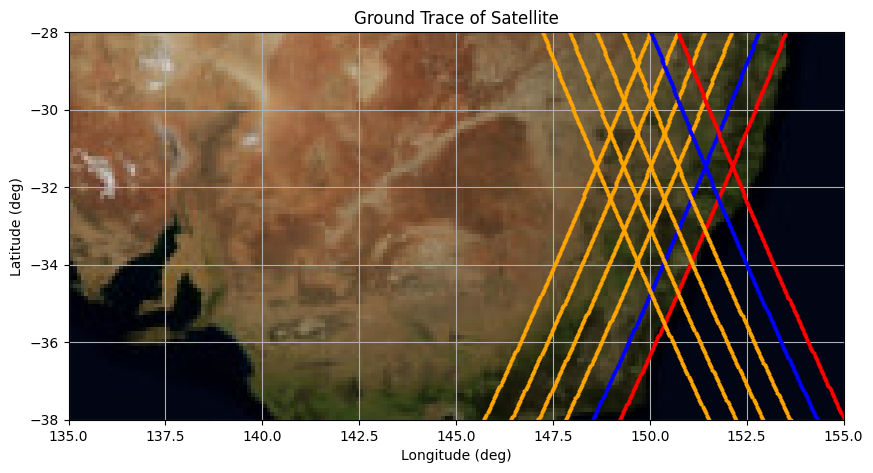

In [23]:
# Load the BlueMarble image
BlueMarble = mpimg.imread('BlueMarble.png')

# Create a 2D plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(BlueMarble, extent=[-180, 180, -90, 90])
ax.grid(True)
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')
ax.set_xlim([135, 155])  # Longitude bounds for NSW
ax.set_ylim([-38, -28])  # Latitude bounds for NSW
ax.set_title('Ground Trace of Satellite')

# Plot the ground trace
ax.plot(LLA[:,1], LLA[:,0], marker = 'o',linestyle = 'none',color='red', markersize=2, label='Satellite Ground Trace')
ax.plot(LLA2[:,1], LLA2[:,0], marker = 'o',linestyle = 'none',color='blue', markersize=2, label='Satellite Ground Trace 2')
ax.plot(LLA3[:,1], LLA3[:,0], marker = 'o',linestyle = 'none',color='orange', markersize=2, label='Satellite Ground Trace 3')
ax.plot(LLA4[:,1], LLA4[:,0], marker = 'o',linestyle = 'none',color='orange', markersize=2, label='Satellite Ground Trace 4')
ax.plot(LLA5[:,1], LLA5[:,0], marker = 'o',linestyle = 'none',color='orange', markersize=2, label='Satellite Ground Trace 3')
ax.plot(LLA6[:,1], LLA6[:,0], marker = 'o',linestyle = 'none',color='orange', markersize=2, label='Satellite Ground Trace 4')

ax.plot(phaseLLA[:,1], phaseLLA[:,0], marker = 'o',linestyle = 'none',color='red', markersize=2, label='Satellite Ground Trace')
ax.plot(phaseLLA2[:,1], phaseLLA2[:,0], marker = 'o',linestyle = 'none',color='blue', markersize=2, label='Satellite Ground Trace 2')
ax.plot(phaseLLA3[:,1], phaseLLA3[:,0], marker = 'o',linestyle = 'none',color='orange', markersize=2, label='Satellite Ground Trace 3')
ax.plot(phaseLLA4[:,1], phaseLLA4[:,0], marker = 'o',linestyle = 'none',color='orange', markersize=2, label='Satellite Ground Trace 4')
ax.plot(phaseLLA5[:,1], phaseLLA5[:,0], marker = 'o',linestyle = 'none',color='orange', markersize=2, label='Satellite Ground Trace 3')
ax.plot(phaseLLA6[:,1], phaseLLA6[:,0], marker = 'o',linestyle = 'none',color='orange', markersize=2, label='Satellite Ground Trace 4')
plt.show()


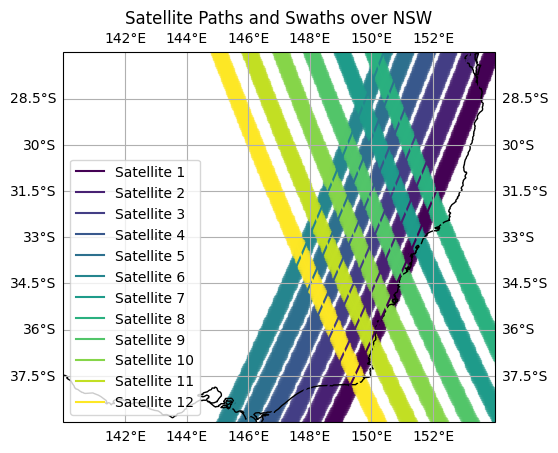

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([140, 154, -39, -27])  # [x0, x1, y0, y1] bounding box around NSW
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

# For 8 satellites, suppose you have LLA1, LLA2, ..., LLA8 as their paths.
# Eg: LLA1 = np.array([[lat1, lon1], [lat2, lon2], ..., [latN, lonN]])
# Combine them into a list for iteration:
LLA_sats = [LLA, LLA2, LLA3, LLA4, LLA5, LLA6, phaseLLA, phaseLLA2, phaseLLA3, phaseLLA4, phaseLLA5, phaseLLA6]  

# Calculated swath widths in degrees (adjust for 40km)
# Ensure the conversion factor is accurate for NSW's latitude for longitude
swath_lat = (45/111)  # Roughly, 1 degree latitude is 111 km
swath_lon = swath_lat  # This might need adjusting for NSW's longitude

colors = plt.cm.viridis(np.linspace(0, 1, len(LLA_sats)))  # Color map for paths

for idx, LLA in enumerate(LLA_sats):
    # Plot satellite path
    ax.plot(LLA[:,1], LLA[:,0], color=colors[idx], transform=ccrs.PlateCarree(), label=f'Satellite {idx+1}')

    # Plot swath around each point
    for coord in LLA:
        ax.add_patch(plt.Rectangle((coord[1]-swath_lon/2, coord[0]-swath_lat/2), 
                                    swath_lon, swath_lat, 
                                    color=colors[idx], alpha=0.5, 
                                    transform=ccrs.PlateCarree()))

ax.set_title('Satellite Paths and Swaths over NSW')
ax.legend(loc='lower left')
plt.show()
